# Figure: within-subject encoding

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

from collections import defaultdict

import h5py
import cortex
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

from statsmodels.stats.multitest import multipletests
from scipy import stats

from util import plot
from util.path import Path
from util.atlas import Atlas, get_brainmask
from constants import SUBS_STRANGERS, BLU, ORG

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
# modelname = "model-gpt2-2b_layer-24"
modelname = "model-opt-7b_layer-23"

# features = ["task", "prod-LLM", "comp-LLM"]
features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding/trialmot6"

# cache = 'nomot'  # no motion confounds at all
cache = encmodel.split("/")[-1]

modelname, encmodel, cache

('model-opt-7b_layer-23', 'encoding/trialmot6', 'trialmot6')

# Load results

In [4]:
respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

results = defaultdict(list)
for sub in tqdm(SUBS_STRANGERS):
    respath.update(sub=f"{sub:03d}")
    if not respath.isfile():
        print("skip", sub)
        continue
    with h5py.File(respath, "r") as f:
        for key in ["cv_scores_prod", "cv_scores_comp"]:  # , "cv_scores"]:
            results[key].append(f[key][...])
        # results['inprod'].append(f['cv_prodmask'][...])

100%|██████████| 58/58 [00:10<00:00,  5.50it/s]


In [5]:
# scores without splitting into prod/comp time points
all_scores_prod = np.stack(results["cv_scores_prod"])  # sub, run, feature, voxel
all_scores_comp = np.stack(results["cv_scores_comp"])  # sub, run, feature, voxel
all_scores_lang = (all_scores_prod[:, :, -2] + all_scores_comp[:, :, -1]).mean(1)
all_scores_prod.shape

(58, 5, 5, 81924)

In [6]:
avg_scores_prod = all_scores_prod.mean((0, 1))
avg_scores_comp = all_scores_comp.mean((0, 1))
avg_scores_lang = avg_scores_prod[-2] + avg_scores_comp[-1]
avg_scores_prod.shape

(5, 81924)

## Test for significance

In [7]:
fgmask = get_brainmask()


def ttest_sig(
    values: np.ndarray,
    popmean: int = 0,
    correlations: bool = True,
    alternative: str = "two-sided",
    alpha: float = 0.01,
    method="bonf",
):
    if correlations:
        values = np.arctanh(values)

    ttest = stats.ttest_1samp(values, popmean=popmean, alternative=alternative)

    pvalues = ttest.pvalue
    multiple = multipletests(pvalues[fgmask], alpha=alpha, method=method)

    reject = np.zeros_like(pvalues, dtype=bool)
    reject[*fgmask.nonzero()] = multiple[0]

    return reject

In [8]:
sigmask = ttest_sig(all_scores_lang)
sigmask.sum()

36010

# Plot LLM encoding performance

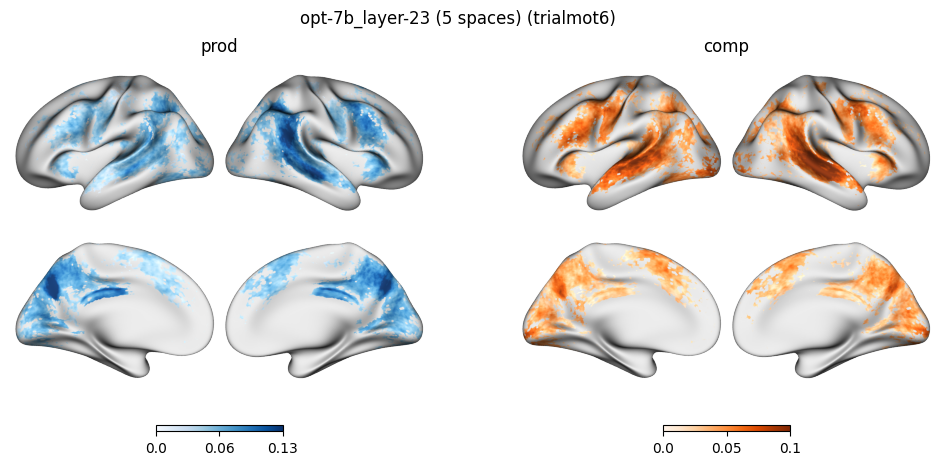

In [9]:
values1 = avg_scores_prod[-2].copy()
values2 = avg_scores_comp[-1].copy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot.surface_plot(
    values1, threshold=~sigmask, fig=fig, ax=axes[0], vmin=0, cmap="Blues", title="prod"
)
plot.surface_plot(
    values2,
    threshold=~sigmask,
    fig=fig,
    ax=axes[1],
    vmin=0,
    cmap="Oranges",
    title="comp",
)
fig.suptitle(modelname[6:] + f" ({len(features)} spaces) ({cache})")
fig.show()

## flatmap

In [10]:
values1[~sigmask] = np.nan
values2[~sigmask] = np.nan
values1 = plot.upsample_fsaverage(values1)
values2 = plot.upsample_fsaverage(values2)
vmin1, vmin2 = None, None
volume = cortex.Vertex2D(
    values1, values2, "fsaverage", cmap="PU_BuOr_covar", vmin=vmin1, vmin2=vmin2
)

/scratch/gpfs/zzada/conda-envs/fconv/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: divide by zero encountered in buffer
  return lib.buffer(


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:4084911): glibmm-WARNING **: 15:36:04.103: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.


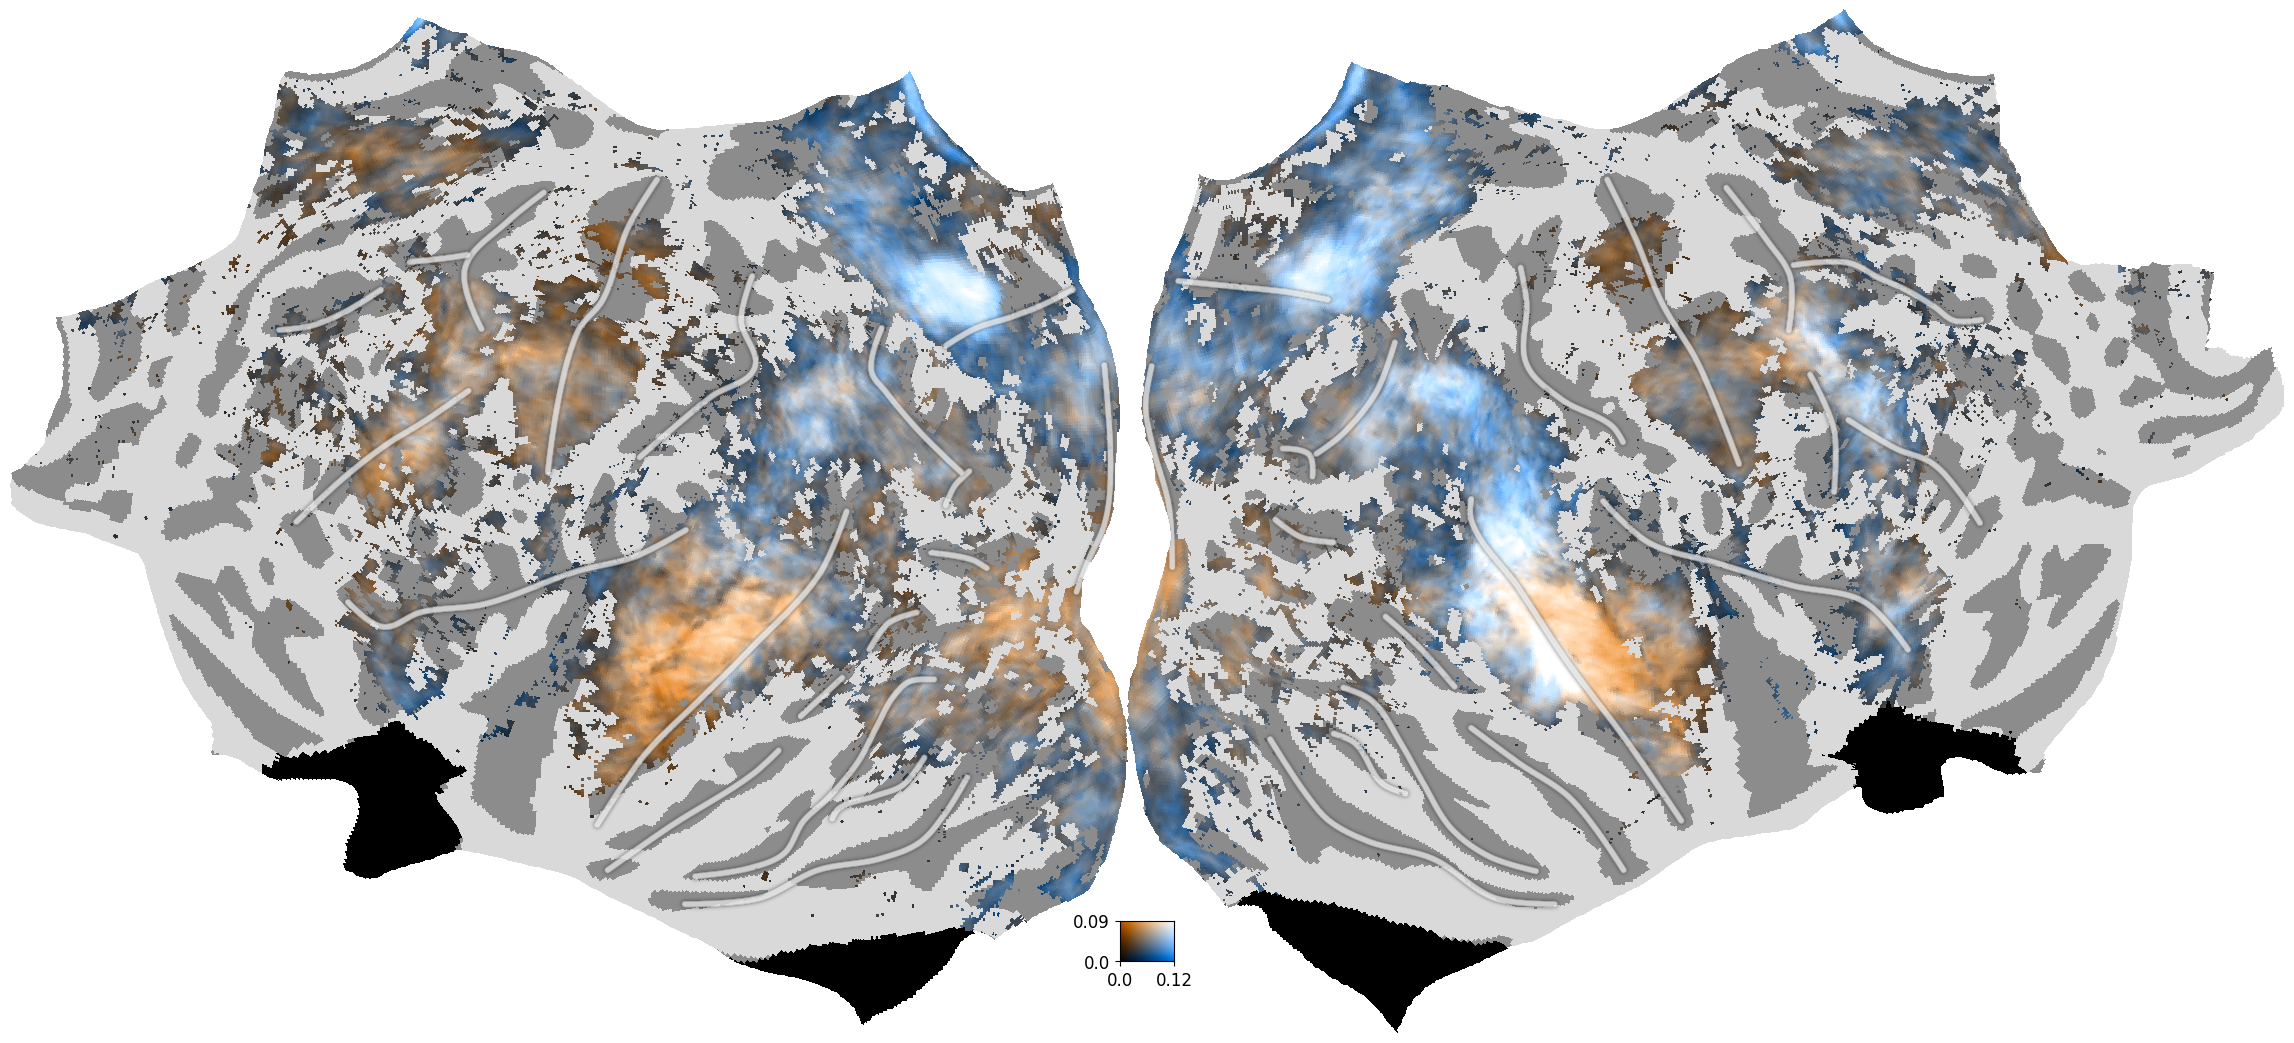

In [11]:
fig = cortex.quickflat.make_figure(
    volume,
    with_sulci=True,
    with_rois=False,
    with_labels=False,
    with_curvature=True,
    curvature_brightness=0.7,
    curvature_contrast=0.3,
)

# scatter prod and comp

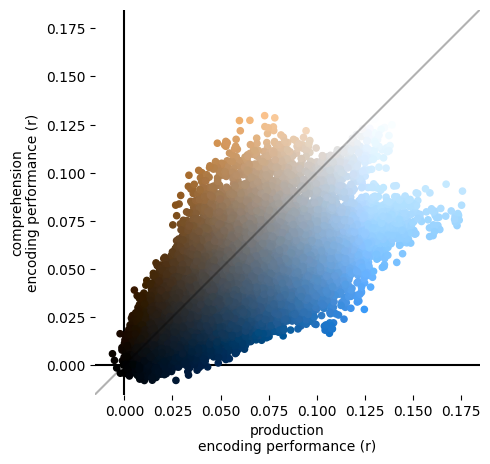

In [12]:
values1 = avg_scores_prod[-2][fgmask]
values2 = avg_scores_comp[-1][fgmask]

vox_colors = plot.Colormap2D(vmin=0, vmin2=0, vmax=0.13, vmax2=0.13)(
    np.vstack((values1, values2)).T
)
vox_colors = np.stack((vox_colors)).T / 255

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

ax.axvline(0, c="k", zorder=1, alpha=1)
ax.axhline(0, c="k", zorder=1, alpha=1)
ax.axline(xy1=(0, 0), slope=1, alpha=0.3, color="k")
# im = ax.hexbin(values1, values2, bins="log", cmap='grey', gridsize=100)
# im = ax.scatter(values1, values2, color='black', edgecolors="white", linewidths=0.5, s=15, marker='o')
im = ax.scatter(
    values1, values2, c=vox_colors, s=20
)  # , edgecolors="white", linewidths=0.5, s=20, marker='o')
ax.set_aspect("equal", "box")

# roi_labels = {
#     "aTemp": "RH_Lang_aSTS",
#     "pTemp": "RH_Lang_pSTS",
#     "EAC": "RH_AUD_EAC",
# }
# for label, roi in roi_labels.items():
#     roimask = catlas.roimask([roi])
#     x_roi = np.mean(values1[roimask[fgmask]])
#     y_roi = np.mean(values2[roimask[fgmask]])
#     ax.text(
#         x_roi,
#         y_roi,
#         label,
#         ha="center",
#         va="center",
#         size=8,
#         bbox=dict(boxstyle="round", ec=(1.0, 1.0, 1.0), fc=(0.8, 0.8, 0.8)),
#     )

lim = max(ax.get_xlim()[1], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], lim)
ax.set_ylim(ax.get_xlim()[0], lim)

ax.set_xlabel("production\nencoding performance (r)")
ax.set_ylabel("comprehension\nencoding performance (r)")

# cbar = fig.colorbar(im, shrink=0.86)
# cbar.set_label("density")

sns.despine(fig, left=True, bottom=True)

fig.show()

# encoding performance per feature space

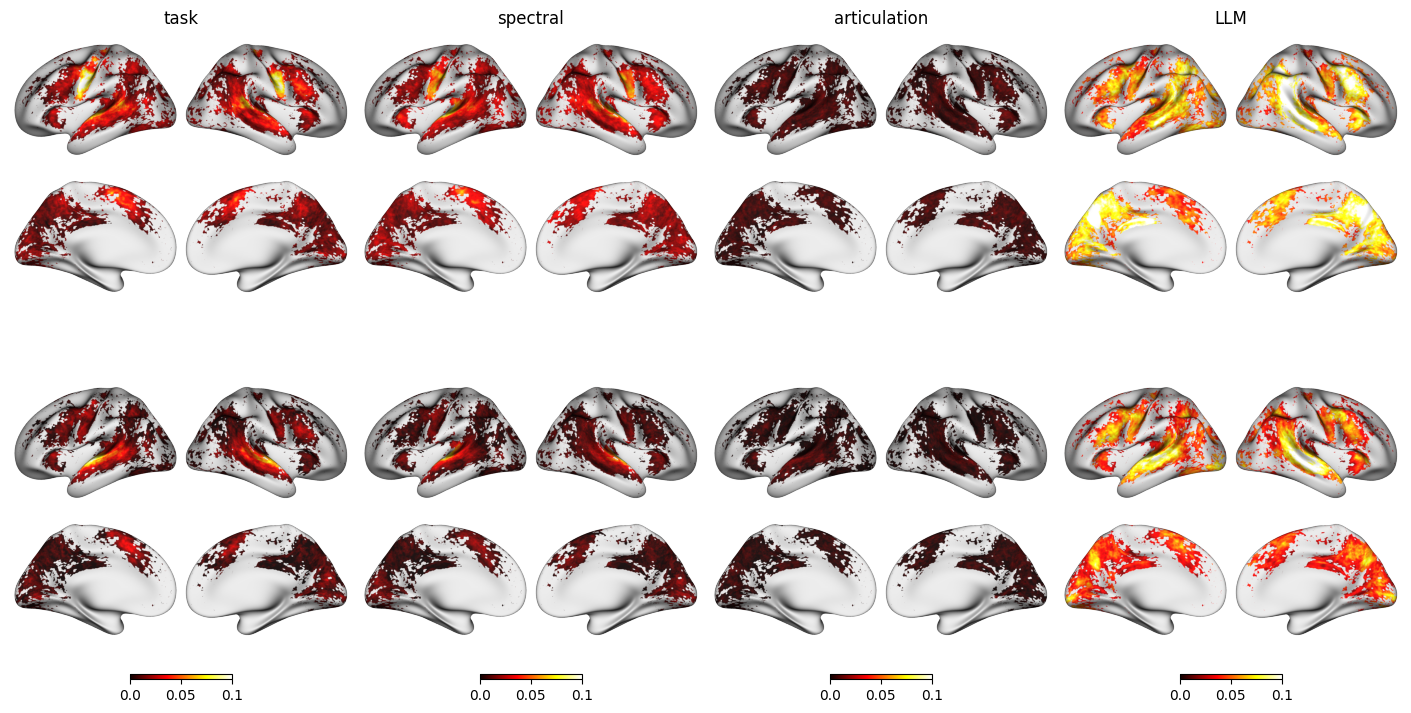

In [13]:
brainmask = ~sigmask

fig, axes = plt.subplots(2, 4, figsize=(14, 7), layout="constrained")
# joint
# plot.surface_plot(avg_scores_prod.sum(0), fig=fig, ax=axes[0,0], vmin=0.0, cmap="hot")
# plot.surface_plot(avg_scores_comp.sum(0), fig=fig, ax=axes[1,0], vmin=0.0, cmap="hot")

plot.surface_plot(
    avg_scores_prod[0],
    threshold=brainmask,
    fig=fig,
    ax=axes[0, 0],
    vmin=0.0,
    vmax=0.1,
    cbar=False,
    cmap="hot",
)
plot.surface_plot(
    avg_scores_comp[0],
    threshold=brainmask,
    fig=fig,
    ax=axes[1, 0],
    vmin=0.0,
    vmax=0.1,
    cbar=True,
    cmap="hot",
)

plot.surface_plot(
    avg_scores_prod[1],
    threshold=brainmask,
    fig=fig,
    ax=axes[0, 1],
    vmin=0.0,
    vmax=0.1,
    cbar=False,
    cmap="hot",
)
plot.surface_plot(
    avg_scores_comp[1],
    threshold=brainmask,
    fig=fig,
    ax=axes[1, 1],
    vmin=0.0,
    vmax=0.1,
    cbar=True,
    cmap="hot",
)

plot.surface_plot(
    avg_scores_prod[2],
    threshold=brainmask,
    fig=fig,
    ax=axes[0, 2],
    vmin=0.0,
    vmax=0.1,
    cbar=False,
    cmap="hot",
)
plot.surface_plot(
    avg_scores_comp[2],
    threshold=brainmask,
    fig=fig,
    ax=axes[1, 2],
    vmin=0.0,
    vmax=0.1,
    cbar=True,
    cmap="hot",
)

plot.surface_plot(
    avg_scores_prod[3],
    threshold=brainmask,
    fig=fig,
    ax=axes[0, 3],
    vmin=0.0,
    vmax=0.1,
    cbar=False,
    cmap="hot",
)
plot.surface_plot(
    avg_scores_comp[4],
    threshold=brainmask,
    fig=fig,
    ax=axes[1, 3],
    vmin=0.0,
    vmax=0.1,
    cbar=True,
    cmap="hot",
)

axes[0, 0].set_title("task")
axes[0, 1].set_title("spectral")
axes[0, 2].set_title("articulation")
axes[0, 3].set_title("LLM")

fig.show()

# joint performance

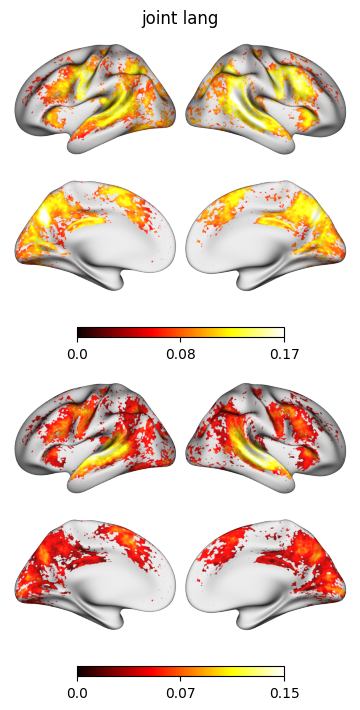

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(7, 7), layout="constrained")

# axes[0].set_title('joint')
# plot.surface_plot(avg_scores_prod.sum(0), threshold=brainmask, fig=fig, ax=axes[0], vmin=0.0, cmap="hot")
# plot.surface_plot(avg_scores_comp.sum(0), threshold=brainmask, fig=fig, ax=axes[1], vmin=0.0, cmap="hot")

axes[0].set_title("joint lang")
plot.surface_plot(
    avg_scores_prod[1:].sum(0),
    threshold=brainmask,
    fig=fig,
    ax=axes[0],
    vmin=0.0,
    cmap="hot",
)
plot.surface_plot(
    avg_scores_comp[1:].sum(0),
    threshold=brainmask,
    fig=fig,
    ax=axes[1],
    vmin=0.0,
    cmap="hot",
)

fig.show()

## ROI-level

In [15]:
catlas = Atlas.load("custom_glasser")

In [16]:
scoresP = catlas.vox_to_parc(avg_scores_prod)
scoresC = catlas.vox_to_parc(avg_scores_comp)
scoresP.shape

(5, 44)

In [17]:
df = pd.DataFrame(index=catlas.labels)
df["task"] = scoresP[0] + scoresC[0]
df["spectral"] = scoresP[1] + scoresC[1]
df["articulation"] = scoresP[2] + scoresC[2]
df["prod-LLM"] = scoresP[3]
df["comp-LLM"] = scoresC[4]
df.head()

,task,spectral,articulation,prod-LLM,comp-LLM
LH_Lang_SFL1,0.029784,0.029193,0.008912,0.046774,0.036977
LH_Lang_SFL2,0.057487,0.052397,0.009819,0.042274,0.045576
LH_MOT_M1,0.054645,0.041248,0.007806,0.037458,0.040346
LH_MOT_S1,0.062004,0.049609,0.008950,0.042040,0.044286
LH_AUD_EAC,0.064852,0.097385,0.010950,0.051039,0.046133


/tmp/ipykernel_4071719/3464109649.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=90)


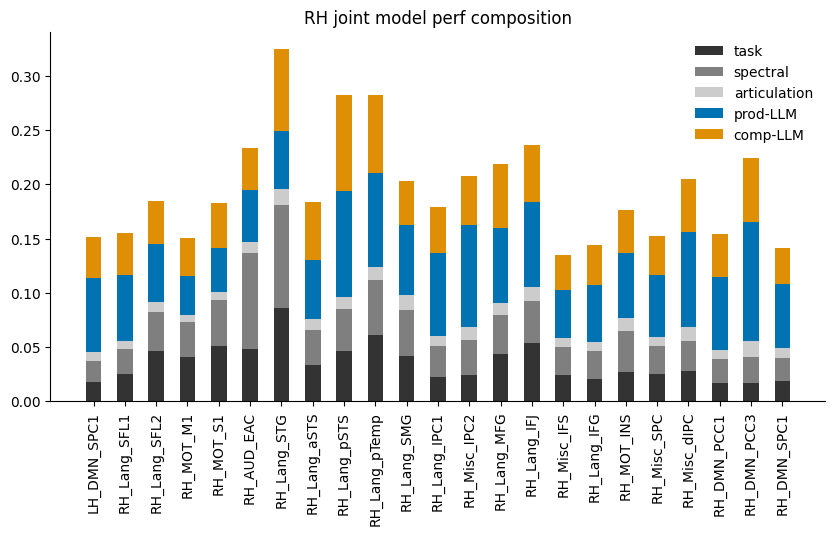

In [18]:
width = 0.5

fig, ax = plt.subplots(figsize=(10, 4.8))

subdf = df.iloc[21:]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#7f7f7f", "#CCCCCC", BLU, ORG]

for feature, color in zip(features, colors):
    values = subdf[feature]
    p = ax.bar(xlabels, values, width, label=feature, bottom=bottom, color=color)
    bottom += values

ax.set_xticklabels(xlabels, rotation=90)

ax.set_title("RH joint model perf composition")
ax.legend(loc="upper right", frameon=False)
sns.despine(fig)

plt.show()

/tmp/ipykernel_4071719/3103306343.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels, rotation=90)


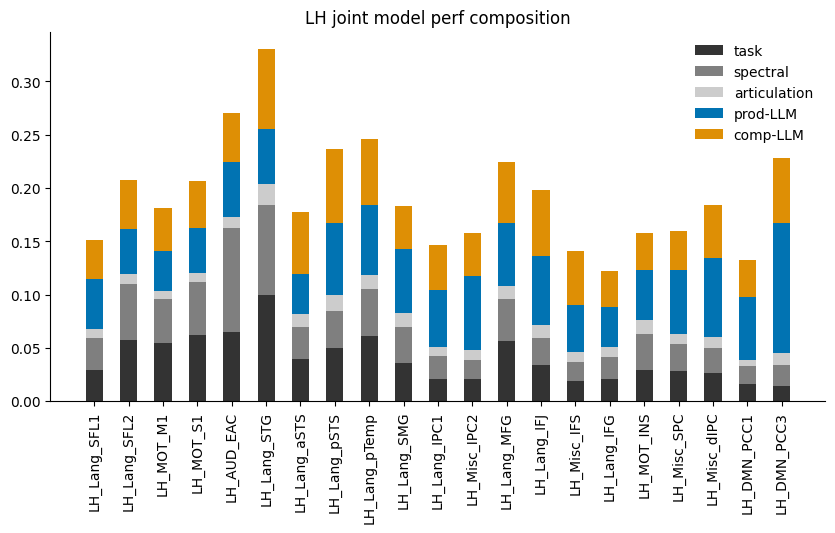

In [19]:
width = 0.5

fig, ax = plt.subplots(figsize=(10, 4.8))

subdf = df.iloc[:21]
xlabels = subdf.index
bottom = np.zeros(len(xlabels))
colors = ["#333333", "#7f7f7f", "#CCCCCC", BLU, ORG]

for feature, color in zip(features, colors):
    values = subdf[feature]
    p = ax.bar(xlabels, values, width, label=feature, bottom=bottom, color=color)
    bottom += values

ax.set_xticklabels(xlabels, rotation=90)

ax.set_title("LH joint model perf composition")
ax.legend(loc="upper right", frameon=False)
sns.despine(fig)

plt.show()